The following code describes learning the images without training the base model and after hyperparameter optimization.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator#, img_to_array, load_img
import random
import keras as ks
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D, Conv2D
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

folders

In [3]:
PATH_TRAIN_CONTROL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TRAIN/0'
PATH_TRAIN_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TRAIN/1'
PATH_TEST_CONTROL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TEST/0'
PATH_TEST_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TEST/1'
PATH_VAL_CONTROL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/VALIDATION/0'
PATH_VAL_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/VALIDATION/1'

list_TEST_acid = os.listdir(PATH_TEST_ACID)
list_VAL_acid = os.listdir(PATH_VAL_ACID)
list_TRAIN_acid = os.listdir(PATH_TRAIN_ACID)

list_TEST_control = os.listdir(PATH_TEST_CONTROL)
list_VAL_control = os.listdir(PATH_VAL_CONTROL)
list_TRAIN_control = os.listdir(PATH_TRAIN_CONTROL)

print('SPLIT DATA:')
print(f"Folder TRAIN_CONTROL: {len(list_TRAIN_control)}")
print(f"Folder TRAIN_aACID: {len(list_TRAIN_acid)}")
print(f"Folder TEST_CONTROL: {len(list_TEST_control)}")
print(f"Folder TEST_ACID: {len(list_TEST_acid)}")
print(f"Folder VALIDATION_CONTROL: {len(list_VAL_control)}")
print(f"Folder VALIDATION_ACID: {len(list_VAL_acid)}")

SPLIT DATA:
Folder TRAIN_CONTROL: 1100
Folder TRAIN_aACID: 1100
Folder TEST_CONTROL: 2200
Folder TEST_ACID: 2200
Folder VALIDATION_CONTROL: 300
Folder VALIDATION_ACID: 300


In [4]:
PATH_TRAIN = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TRAIN'
PATH_TEST = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TEST'
PATH_VAL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/VALIDATION'

PATH_TRAIN_CONTROL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TRAIN/0'
PATH_TRAIN_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TRAIN/1'
PATH_TEST_CONTROL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TEST/0'
PATH_TEST_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/TEST/1'
PATH_VAL_CONTRL = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/VALIDATION/0'
PATH_VAL_ACID = '/content/gdrive/MyDrive/mini-project/bacteria_data/data/data_split_2/VALIDATION/1'

IMG_WIDTH, IMG_HEIGHT = 250, 250
BATCH_SIZE = 16

Generator for train and validation including augmentation

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           featurewise_center=False,  # set input mean to 0 over the dataset
                                           samplewise_center=False,  # set each sample mean to 0
                                           featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                           samplewise_std_normalization=False,  # divide each input by its std
                                           zca_whitening=False,  # apply ZCA whitening
                                           rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                                           width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                           height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                           fill_mode='constant',  # fill shifted pixels with a constant value
                                           cval=0,  # set the constant value to 0 (black)
                                           horizontal_flip=True,  # randomly flip images
                                           vertical_flip=True)  # Generator for our training datavalidation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data


train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=PATH_TRAIN,
                                                           shuffle=True,
                                                           target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                           class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                             directory=PATH_VAL,
                                                             shuffle=False,
                                                             target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                             class_mode='categorical')

Found 2200 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


##model

The training was based on the best model that came out after hyperparameter optimization

the model architecture:

densenet121->
global average pooling 2d->
dense (128)->
dropout(0.4)->
dense(softmax)

In [9]:
best_model_path = '/content/gdrive/MyDrive/mini-project/bacteria_data/hyperparameter_results/best_model.h5'
best_model = load_model(best_model_path)
print(best_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                             

train:

We used checkpoint to save the best model during the training as well as earlystopping to stop the training if there is no progress in the results

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/mini-project/checkpoints/bacteria/final_model_1.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             save_weights_only=False,
                             mode='max',
                             save_freq='epoch')

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max',
                               verbose=1)

EPOCHS = 10
TRAIN_SAMPLES = 2200
VAL_SAMPLES = 600

history = best_model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(TRAIN_SAMPLES / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(VAL_SAMPLES / float(BATCH_SIZE))),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 1: val_accuracy improved from -inf to 0.99333, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/bacteria/final_model_1.h5
138/138 [==============================] - 1122s 8s/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0121 - val_accuracy: 0.9933
Epoch 2/10
138/138 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9991
Epoch 2: val_accuracy improved from 0.99333 to 0.99667, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/bacteria/final_model_1.h5
138/138 [==============================] - 518s 4s/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.0071 - val_accuracy: 0.9967
Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9977
Epoch 3: val_accuracy improved from 0.99667 to 1.00000, saving model to /content/gdrive/MyDrive/mini-project/checkpoints/bacteria/final_model_1.h5
138/138 [

Model evaluation

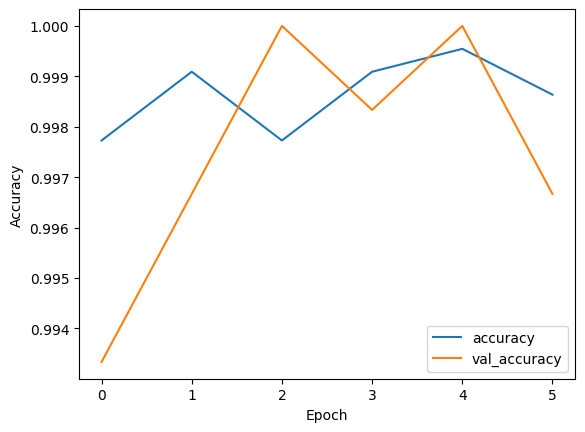

In [11]:
#accuracy plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

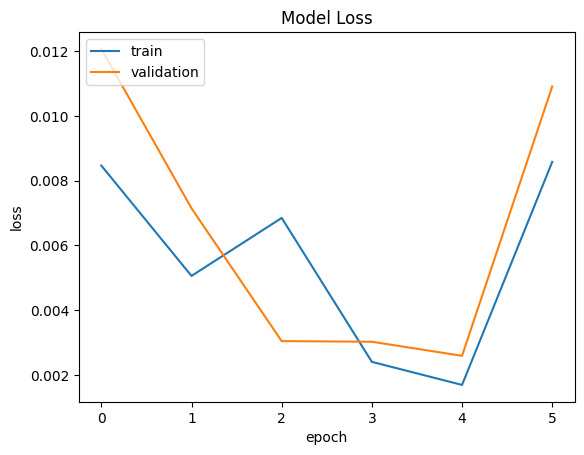

In [13]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Checking on the test with the best model we got from the first training

In [14]:
model = models.load_model('/content/gdrive/MyDrive/mini-project/checkpoints/bacteria/final_model_1.h5') #load the saved model

In [15]:
BATCH_SIZE = 16
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our testing data

test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=PATH_TEST,
                                                           shuffle=False,
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                           class_mode='categorical')

Found 4400 images belonging to 2 classes.


In [16]:
from sklearn.metrics import classification_report
Y_pred = model.predict(test_data_gen, test_data_gen.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_data_gen.classes
print(classification_report(val_trues, val_preds))

275/275 [==============================] - 1224s 4s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2200
           1       1.00      1.00      1.00      2200

    accuracy                           1.00      4400
   macro avg       1.00      1.00      1.00      4400
weighted avg       1.00      1.00      1.00      4400



In [17]:
import sklearn.metrics as metrics
val_preds = np.argmax(Y_pred, axis=1)
val_trues = test_data_gen.classes
CM = metrics.confusion_matrix(val_trues, val_preds)
print(CM)

[[2192    8]
 [   4 2196]]


In [18]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(val_trues, Y_pred[:, 1])  # Assuming the positive class is at index 1
print("AUC Score:", auc_score)

AUC Score: 0.99995


We can see that the model made only 12 mistakes.